In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import networkx as nx
from skimage.io import imread

/Users/mingyuzhu/opt/anaconda3/envs/comp_graph_theory/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The following function takes a binary image representation and a filter size. It applies a filter to the binary image to determine where the main object is and return a starting point for drawing the initial triangle
def get_image_start_pts(img, filter_size):
    my_filter = np.random.random([filter_size, filter_size])
    convolved = convolve(img, my_filter)
    max_idx = np.unravel_index(np.argmax(convolved),convolved.shape)
    return max_idx

In [3]:
#create triangle of a given side length that is positioned upright
def create_triangle(min_len,max_len):
    side_length = np.random.random() * (max_len - min_len) + min_len
    base_coor = (0, 0)
    c = np.tan(np.pi / 6) * (side_length / 2)
    A = (base_coor[0], base_coor[1] + np.sqrt(3) / 2 * side_length - c)
    B = (base_coor[0] -side_length / 2, base_coor[1]  -c)
    C = (base_coor[0] + side_length / 2, base_coor[1]  -c)
    return np.array([A, B, C])

In [4]:
# Help determine if the vertex of the new triangle already exists in the graph,
# if exists, return the position symmetric in respect to the line connected by
# node1 and node2
def triangle_helper(node1,node2,vert_locs):
    node1 = np.array(node1)
    node2 = np.array(node2)
    center = np.array([(node1[0] + node2[0]) / 2, (node1[1] + node2[1])/2])

    vec = node1 - node2
    len_vec = (vec[0]**2 + vec[1]**2)**(0.5)
    dir = np.dot(np.array([[0,-1],[1,0]]), (vec / len_vec))


    pt1 = center + dir * np.sqrt(3) / 2 * len_vec
    pt2 = center + dir * np.sqrt(3) / 2 * len_vec * (-1)

    min_dis_1 = 10000
    closest_neighbor_1 = None
    min_dis_2 = 10000
    closest_neighbor_2 = None

    #check if pt1 is already in vert_locs
    for i in range(len(vert_locs)):
        vert = vert_locs[i]
        dis = np.sqrt((vert[0] - pt1[0])**2 + (vert[1] - pt1[1])**2)
        if (dis < min_dis_1):
            min_dis_1 = dis
            closest_neighbor_1 = i

    for i in range(len(vert_locs)):
        vert = vert_locs[i]
        dis = np.sqrt((vert[0] - pt2[0])**2 + (vert[1] - pt2[1])**2)
        if (dis < min_dis_2):
            min_dis_2 = dis
            closest_neighbor_2 = i

    #closure
    if (min_dis_1 < len_vec / 100 and min_dis_2 < len_vec/100):
        return True, [pt1,pt2,closest_neighbor_1,closest_neighbor_2]

    else:
        if (min_dis_1 <= len_vec / 100):
            return False, [pt2]
        else:
            return False, [pt1]

# Take in two nodes, return the center of the line that connects these two nodes
def edge_sampler(node1,node2):
    node1 = np.array(node1)
    node2 = np.array(node2)
    center = np.array([(node1[0] + node2[0]) / 2, (node1[1] + node2[1])/2])
    return int(center[0]),int(center[1])

# Checks if the coordinate (x,y) is within the highlighted part of the image
def point_valid(x,y,img):
    if (x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[1]):
        return img[int(x), int(y)] == 1
    else:
        return False

# The original function to create random triangular mesh. The founding function of all other triangular-mesh generators
def create_multi_triangle():
    source = create_triangle(5,5)
    vertice_locations = [(source[0,0],source[0,1]),(source[1,0],source[1,1]),(source[2,0],source[2,1])]
    edges = [set([0,1]),set([0,2]),set([1,2])]
    outer_edges = edges.copy()
    triangles = [set([0,1,2])]

    case_1_on = True
    case_2_on = True
    case_3_on = True


    n = 0
    while n < 100:
        n += 1
        rand_idx = np.random.randint(0,len(outer_edges))
        orig_ver1 = list(outer_edges[rand_idx])[0]
        orig_ver2 = list(outer_edges[rand_idx])[1]
        closure, new_vertexs = triangle_helper(vertice_locations[orig_ver1],vertice_locations[orig_ver2], vertice_locations)

        if closure == False:
            new_vertex = new_vertexs[0]

            vertice_locations.append((new_vertex[0],new_vertex[1]))
            new_edge1 = set([orig_ver1,len(vertice_locations)-1])
            new_edge2 = set([orig_ver2,len(vertice_locations)-1])

            edges.append(new_edge1)
            edges.append(new_edge2)

            triangles.append(set([orig_ver1, orig_ver2, len(vertice_locations)-1]))

            outer_edges.remove(set([orig_ver1,orig_ver2]))
            outer_edges.append(new_edge1)
            outer_edges.append(new_edge2)


        else:
            clo_nei1 = new_vertexs[2]
            clo_nei2 = new_vertexs[3]

            #don't try to understand this
            c1o1 = set([clo_nei1, orig_ver1]) not in edges
            c1o2 = set([clo_nei1, orig_ver2]) not in edges
            c2o1 = set([clo_nei2, orig_ver1]) not in edges
            c2o2 = set([clo_nei2, orig_ver2]) not in edges


            #rnm case 1
            if ((not c1o1) and (not c1o2) ) and ((not c2o1) and (not c2o2)):
                if (case_1_on):
                    if set([orig_ver1,orig_ver2,clo_nei1]) in triangles:
                        triangles.append(set([clo_nei2,orig_ver1,orig_ver2]))

                        outer_edges.remove(set([orig_ver1,orig_ver2]))
                        outer_edges.remove(set([clo_nei2,orig_ver1]))
                        outer_edges.remove(set([clo_nei2,orig_ver2]))


                    else:
                        triangles.append(set([clo_nei1,orig_ver1,orig_ver2]))

                        outer_edges.remove(set([orig_ver1,orig_ver2]))
                        outer_edges.remove(set([clo_nei1,orig_ver1]))
                        outer_edges.remove(set([clo_nei1,orig_ver2]))
                else:
                    n -= 1


            #rnm case 2
            elif (c1o1 and c1o2) or (c2o1 and c2o2):
                if (case_2_on):
                    if (c1o1 and c1o2):
                        new_edge1 = set([clo_nei1,orig_ver1])
                        new_edge2 = set([clo_nei1,orig_ver2])



                        edges.append(new_edge1)
                        edges.append(new_edge2)

                        triangles.append(set([clo_nei1,orig_ver1,orig_ver2]))

                        outer_edges.remove(outer_edges[rand_idx])

                        outer_edges.append(new_edge1)
                        outer_edges.append(new_edge2)

                    else:
                        new_edge1 = set([clo_nei2,orig_ver1])
                        new_edge2 = set([clo_nei2,orig_ver2])
                        edges.append(new_edge1)
                        edges.append(new_edge2)

                        triangles.append(set([clo_nei2,orig_ver1,orig_ver2]))

                        outer_edges.remove(outer_edges[rand_idx])

                        outer_edges.append(new_edge1)
                        outer_edges.append(new_edge2)
                else:
                    n -= 1


            #rnm case 3
            else:
                if (case_3_on):
                    if set([orig_ver1,clo_nei1]) not in edges:
                        new_edge = set([orig_ver1,clo_nei1])

                        edges.append(new_edge)

                        triangles.append(set([orig_ver1,orig_ver2,clo_nei1]))

                        outer_edges.remove(outer_edges[rand_idx])

                        outer_edges.remove(set([clo_nei1,orig_ver2]))

                        outer_edges.append(new_edge)


                    elif set([orig_ver1,clo_nei2]) not in edges:
                        new_edge = set([orig_ver1,clo_nei2])

                        edges.append(new_edge)

                        triangles.append(set([orig_ver1,orig_ver2,clo_nei2]))

                        outer_edges.remove(outer_edges[rand_idx])
                        outer_edges.remove(set([clo_nei2,orig_ver2]))

                        outer_edges.append(new_edge)

                    elif set([orig_ver2,clo_nei1]) not in edges:
                        new_edge = set([orig_ver2,clo_nei1])
                        edges.append(new_edge)

                        triangles.append(set([orig_ver1,orig_ver2,clo_nei1]))

                        outer_edges.remove(outer_edges[rand_idx])
                        outer_edges.remove(set([clo_nei1,orig_ver1]))


                        outer_edges.append(new_edge)
                    else:
                        new_edge = set([orig_ver2,clo_nei2])
                        edges.append(new_edge)
                        triangles.append(set([orig_ver1,orig_ver2,clo_nei2]))

                        outer_edges.remove(outer_edges[rand_idx])
                        outer_edges.remove(set([clo_nei2,orig_ver1]))


                        outer_edges.append(new_edge)

                else:
                    n -= 1


    print(len(triangles))
    temp = []
    for t in triangles:
        if t not in temp:
            temp.append(t)

    print(len(temp))


    return vertice_locations,edges, outer_edges

# The following function takes in an image and then generates a triangular mesh of the object in the image given other arguments
def create_multi_triangle_img(img, triangle_size, max_iteration, start_x, start_y):
    source = create_triangle(triangle_size,triangle_size)

    source = source + np.array([start_x,start_y])

    vertice_locations = [(source[0,0],source[0,1]),(source[1,0],source[1,1]),(source[2,0],source[2,1])]
    edges = [set([0,1]),set([0,2]),set([1,2])]
    outer_edges = edges.copy()
    boundary_edges = []
    triangles = [set([0,1,2])]

    case_1_on = True
    case_2_on = True
    case_3_on = True

    num_remove_errors = 0

    n = 0
    while n < max_iteration and len(outer_edges) > 0:
        n += 1
        rand_idx = np.random.randint(0,len(outer_edges))
        orig_ver1 = list(outer_edges[rand_idx])[0]
        orig_ver2 = list(outer_edges[rand_idx])[1]
        closure, new_vertexs = triangle_helper(vertice_locations[orig_ver1],vertice_locations[orig_ver2], vertice_locations)

        if closure == False:
            new_vertex = new_vertexs[0]

            if point_valid(new_vertex[0],new_vertex[1],img):

                vertice_locations.append((new_vertex[0],new_vertex[1]))
                new_edge1 = set([orig_ver1,len(vertice_locations)-1])
                new_edge2 = set([orig_ver2,len(vertice_locations)-1])

                edges.append(new_edge1)
                edges.append(new_edge2)

                triangles.append(set([orig_ver1, orig_ver2, len(vertice_locations)-1]))

                outer_edges.remove(set([orig_ver1,orig_ver2]))
                outer_edges.append(new_edge1)
                outer_edges.append(new_edge2)

            else:
                outer_edges.remove(set([orig_ver1,orig_ver2]))
                boundary_edges.append(set([orig_ver1,orig_ver2]))


        else:
            clo_nei1 = new_vertexs[2]
            clo_nei2 = new_vertexs[3]

            #don't try to understand this
            c1o1 = set([clo_nei1, orig_ver1]) not in edges
            c1o2 = set([clo_nei1, orig_ver2]) not in edges
            c2o1 = set([clo_nei2, orig_ver1]) not in edges
            c2o2 = set([clo_nei2, orig_ver2]) not in edges

            #rnm case 1
            if ((not c1o1) and (not c1o2) ) and ((not c2o1) and (not c2o2)):
                if (case_1_on):
                    if set([orig_ver1,orig_ver2,clo_nei1]) in triangles:
                        triangles.append(set([clo_nei2,orig_ver1,orig_ver2]))

                        try:
                            outer_edges.remove(set([orig_ver1,orig_ver2]))
                        except:
                            num_remove_errors += 1

                        try:
                            outer_edges.remove(set([clo_nei2,orig_ver1]))
                        except:
                            num_remove_errors += 1

                        try:
                            outer_edges.remove(set([clo_nei2,orig_ver2]))
                        except:
                            num_remove_errors += 1

                    else:
                        triangles.append(set([clo_nei1,orig_ver1,orig_ver2]))

                        try:
                            outer_edges.remove(set([orig_ver1,orig_ver2]))
                        except:
                            num_remove_errors += 1
                        try:
                            outer_edges.remove(set([clo_nei1,orig_ver1]))
                        except:
                            num_remove_errors += 1

                        try:
                            outer_edges.remove(set([clo_nei1,orig_ver2]))
                        except:
                            num_remove_errors += 1
                else:
                    n -= 1
                    boundary_edges.append(outer_edges[rand_idx])
                    outer_edges.remove(outer_edges[rand_idx])


            #rnm case 2
            elif (c1o1 and c1o2) or (c2o1 and c2o2):
                if (case_2_on):
                    if (c1o1 and c1o2):
                        new_edge1 = set([clo_nei1,orig_ver1])
                        new_edge2 = set([clo_nei1,orig_ver2])
                        edges.append(new_edge1)
                        edges.append(new_edge2)

                        center_1 = edge_sampler(vertice_locations[clo_nei1],vertice_locations[orig_ver1])
                        center_2 = edge_sampler(vertice_locations[clo_nei1],vertice_locations[orig_ver2])

                        triangles.append(set([clo_nei1,orig_ver1,orig_ver2]))

                        outer_edges.remove(outer_edges[rand_idx])

                        if point_valid(center_1[0],center_1[1],img):
                            outer_edges.append(new_edge1)
                        else:
                            boundary_edges.append(new_edge1)

                        if point_valid(center_2[0],center_2[1],img):
                            outer_edges.append(new_edge2)
                        else:
                            boundary_edges.append(new_edge2)

                    else:
                        new_edge1 = set([clo_nei2,orig_ver1])
                        new_edge2 = set([clo_nei2,orig_ver2])
                        edges.append(new_edge1)
                        edges.append(new_edge2)

                        center_1 = edge_sampler(vertice_locations[clo_nei2],vertice_locations[orig_ver1])
                        center_2 = edge_sampler(vertice_locations[clo_nei2],vertice_locations[orig_ver2])

                        triangles.append(set([clo_nei2,orig_ver1,orig_ver2]))

                        outer_edges.remove(outer_edges[rand_idx])

                        if point_valid(center_1[0],center_1[1],img):
                            outer_edges.append(new_edge1)
                        else:
                            boundary_edges.append(new_edge1)

                        if point_valid(center_2[0],center_2[1],img):
                            outer_edges.append(new_edge2)
                        else:
                            boundary_edges.append(new_edge2)
                else:
                    n -= 1
                    boundary_edges.append(outer_edges[rand_idx])
                    outer_edges.remove(outer_edges[rand_idx])


            #rnm case 3
            else:
                if (case_3_on):
                    if set([orig_ver1,clo_nei1]) not in edges:
                        new_edge = set([orig_ver1,clo_nei1])

                        center = edge_sampler(vertice_locations[orig_ver1],vertice_locations[clo_nei1])

                        edges.append(new_edge)

                        triangles.append(set([orig_ver1,orig_ver2,clo_nei1]))

                        outer_edges.remove(outer_edges[rand_idx])

                        try:
                            outer_edges.remove(set([clo_nei1,orig_ver2]))
                        except:
                            num_remove_errors += 1

                        if point_valid(center[0],center[1],img):
                            outer_edges.append(new_edge)
                        else:
                            boundary_edges.append(new_edge)


                    elif set([orig_ver1,clo_nei2]) not in edges:
                        new_edge = set([orig_ver1,clo_nei2])

                        center = edge_sampler(vertice_locations[orig_ver1],vertice_locations[clo_nei2])

                        edges.append(new_edge)

                        triangles.append(set([orig_ver1,orig_ver2,clo_nei2]))

                        outer_edges.remove(outer_edges[rand_idx])

                        try:
                            outer_edges.remove(set([clo_nei2,orig_ver2]))
                        except:
                            num_remove_errors += 1

                        if point_valid(center[0],center[1],img):
                            outer_edges.append(new_edge)
                        else:
                            boundary_edges.append(new_edge)

                    elif set([orig_ver2,clo_nei1]) not in edges:
                        new_edge = set([orig_ver2,clo_nei1])

                        center = edge_sampler(vertice_locations[orig_ver2],vertice_locations[clo_nei1])

                        edges.append(new_edge)

                        triangles.append(set([orig_ver1,orig_ver2,clo_nei1]))

                        outer_edges.remove(outer_edges[rand_idx])

                        try:
                            outer_edges.remove(set([clo_nei1,orig_ver1]))
                        except:
                            num_remove_errors += 1


                        if point_valid(center[0],center[1],img):
                            outer_edges.append(new_edge)
                        else:
                            boundary_edges.append(new_edge)
                    else:
                        new_edge = set([orig_ver2,clo_nei2])

                        center = edge_sampler(vertice_locations[orig_ver2],vertice_locations[clo_nei2])

                        edges.append(new_edge)
                        triangles.append(set([orig_ver1,orig_ver2,clo_nei2]))

                        outer_edges.remove(outer_edges[rand_idx])
                        try:
                            outer_edges.remove(set([clo_nei2,orig_ver1]))
                        except:
                            num_remove_errors += 1


                        if point_valid(center[0],center[1],img):
                            outer_edges.append(new_edge)
                        else:
                            boundary_edges.append(new_edge)

                else:
                    n -= 1
                    boundary_edges.append(outer_edges[rand_idx])
                    outer_edges.remove(outer_edges[rand_idx])


    print('total iterations: ', n)

    print('number of triangles: ',len(triangles))
    temp = []
    for t in triangles:
        if t not in temp:
            temp.append(t)

    print('numbwe of unique triangles: ', len(temp))
    print('number of boundary edges: ', len(boundary_edges))
    print('number of remove errors: ', num_remove_errors)

    return vertice_locations,edges, boundary_edges


In [ ]:
# Read in an image
img = imread('buck_binary.png')
# Convert the image to binary
img = np.where(img > 200, 1, 0)
# Get a starting position to draw the first triangle
(x,y) = get_image_start_pts(img,5)

In [26]:
# Create a triangular mesh of the image
vertices, edges, boundary_edges = create_multi_triangle_img(img,15,3000, x,y)
vertices_np = np.array(vertices)
g = nx.Graph()
# Adding all the edges into a graph
for edge in edges:
    g.add_edge(list(edge)[0],list(edge)[1])

total iterations:  2441
number of triangles:  2276
numbwe of unique triangles:  2276
number of boundary edges:  166
number of remove errors:  0


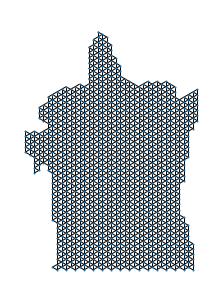

In [27]:
# Make the mesh graph upright
vertices_np = np.flip(vertices_np,axis = 1)
vertices_np[:,1] = img.shape[0] - vertices_np[:,1]
nx.draw(g,pos = vertices_np,node_size = 1)
plt.gca().set_aspect('equal', adjustable='box')

In [13]:
#randomly rotates a triangle
def random_rotation(coords):
    angle = np.random.random() *2
    mat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

    transformed = []

    for i in range(coords.shape[0]):
        transformed.append(mat.dot(coords[i]))

    return np.array(transformed)

#randomly translates a triangle
def random_translation(coords):
    trans = (np.random.random(size=2)-0.5) * np.array([40, 40]) + np.array([32,32])

    return coords + trans

def random_shearing(coords):
    toret = np.empty([coords.shape[0],coords.shape[1]])
    random_shear = np.random.random([2,2]) - 0.5
    random_shear[0,0] = 1
    random_shear[1,1] = 1
    for i in range(coords.shape[0]):
        toret[i,:] = random_shear.dot(coords[i])

    return toret


#generate a triangle and then apply a random rotation and translation
def random_trig_generation(low,high):
    orig = create_triangle(low,high)
    sheared = random_shearing(orig)
    rot = random_rotation(sheared)
    coords = random_translation(rot)
    coords = np.array(coords,dtype=np.int32)

    return coords


In [14]:
#given coordinates of a triangle, draw it in a blank image
def draw_triangle(coords):
    canvas = np.zeros([64,64,3])
    cv2.drawContours(canvas, [coords], -1, (255,255,255), -1)
    bin_img = canvas[:,:,0]
    #bin_img = cv2.threshold(canvas,128,255,cv2.THRESH_BINARY)[1]

    return bin_img


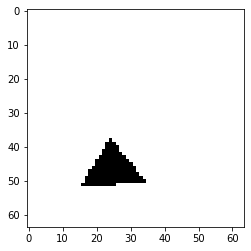

In [15]:
a = random_trig_generation(8,16)
plt.imshow(draw_triangle(a),cmap = 'binary')

In [87]:
min_side_length = 12
max_side_length = 12
train_size = 1000
test_size = 100

In [88]:
#Create the training set
coords = []
imgs = []

for n in range(train_size):
    coord = random_trig_generation(min_side_length,max_side_length)
    img = draw_triangle(coord)
    coords.append(coord)
    imgs.append(img)

#save the training set
imgs = np.array(imgs)
print(imgs.shape)
coords = np.array(coords)
np.save("data/train_imgs.npy",imgs)
np.save("data/train_coords.npy",coords)

(1000, 64, 64)


In [89]:
#Create the testing set
coords = []
imgs = []

for n in range(test_size):
    coord = random_trig_generation(min_side_length,max_side_length)
    img = draw_triangle(coord)
    coords.append(coord)
    imgs.append(img)

#save the training set
imgs = np.array(imgs)
print(imgs.shape)
coords = np.array(coords)
np.save("data/test_imgs.npy",imgs)
np.save("data/test_coords.npy",coords)

(100, 64, 64)


1.8.0
